In [1]:
from __future__ import print_function, division
%run ../basics.ipynb

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['show_config']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Loading BokehJS ...

Using Theano backend.


In [25]:
df = pd.read_csv('../data/auto_tagging_training_testing_confirmed_tags_2016_09_06.csv')
df['tag'] = df['tag'].apply(lambda x: ' '.join(x.split(' | '))) # exact tags
#df['tag'] = df['all_tag'].apply(lambda x: ' '.join(set([j for i in map(lambda y: y.split('>')[1:], 
#                                                                       x.split(' | ')) for j in i]))) # full tags
display(df.head(2))

print(df.columns)
print(df.count()/len(df)*100)

,id,description,title,subtitle,syllabus,tag,all_tag,fold_num
0,http://videolectures.net/acml2013_herbrich_rea...,The last ten years have seen a tremendous grow...,"Distributed, Real-Time Bayesian Learning in On...",NaN,NaN,in_depth machine_learning video,resource_depth>in_depth | data_science_process...,2
1,http://videolectures.net/acml2013_lin_cost_sen...,Classification is an important problem in mach...,Cost-sensitive Classification: Algorithms and ...,NaN,NaN,in_depth machine_learning video,resource_depth>in_depth | data_science_process...,2


Index([u'id', u'description', u'title', u'subtitle', u'syllabus', u'tag',
       u'all_tag', u'fold_num'],
      dtype='object')
id             100.000000
description     83.535109
title          100.000000
subtitle        28.087167
syllabus        11.138015
tag            100.000000
all_tag        100.000000
fold_num       100.000000
dtype: float64


In [3]:
#df = df[df[['title', 'subtitle', 'description', 'syllabus']].apply(lambda x: len((' '.join(map(str,x))).split()), axis=1) >= 100]

In [13]:
class CLF(BaseEstimator):
    def __init__(self, n_topics=20, tfidf_max_df=1., tfidf_min_df=0.,
                 ngram_range=(1, 1), nmf=True, columns=None, stop_words=None, threshold=.5,
                 n_neighbors=5, weights='uniform', 
                 metric='minkowski'):
        
        self.n_topics = n_topics
        self.stop_words = stop_words
        
        self.ngram_range = ngram_range
        self.tfidf_min_df = tfidf_min_df
        self.tfidf_max_df = tfidf_max_df
        self.vectorizer = None
        self.threshold = threshold
        
        self.n_neighbors=n_neighbors
        self.weights=weights
        self.metric=metric
        
        self.tag_vectorizer = None
        
        self.use_nmf = nmf
        self.nmf = None
        self.rf = None
        self.topic_dict = None
        self.columns = columns

    def fit(self, X, y, viz=False):
        self.vectorizer = TfidfVectorizer(stop_words=self.stop_words,
                                  max_df=self.tfidf_max_df,
                                  min_df=self.tfidf_min_df,
                                  ngram_range=self.ngram_range)
        self.tag_vectorizer = CountVectorizer()
        self.rf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=self.n_neighbors,
                                                           weights=self.weights,
                                                           metric=self.metric,
                                                           algorithm='brute'))
        
        if self.use_nmf:
            self.nmf = NMF(n_components=self.n_topics, random_state=2016)
        else:
            self.nmf = None
        orig_X = X.copy()
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=True, viz=viz)
        if viz:
            try:
                tsne_plot(X, orig_X[[orig_X.columns[0]]], fit=True)
            except:
                print(traceback.format_exc())
        y = self.vectorize_y(y, fit=True)
        filt = np.array(y.sum(axis=1) > 0).flatten() # don't train on untagged resources
        if sum(filt) != y.shape[0]:
            #print('excluding untagged resources for clf training')
            #print(y.shape[0], end=' -> ')
            y = y[filt, :]
            X = X[filt, :]
            #print(y.shape[0])
        self.rf.fit(X, y)
        
    def predict(self, X):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=False)
        return self.rf.predict_proba(X)
    
    def prepare_X(self, X):
        if isinstance(X, pd.DataFrame):
            if self.columns is not None:
                X = X[self.columns]
            concat_x = pd.Series(index=X.index, data='')
            for i in X.columns:
                concat_x += ' ' + X[i].apply(text_cleanup)
            X = concat_x
        else:
            assert isinstance(X, pd.Series)
        return X
        
    def vectorize_X(self, X, fit=False, viz=False):
        if fit:
            tfidf = self.vectorizer.fit_transform(X.values)
        else:
            tfidf = self.vectorizer.transform(X.values)
        tfidf, words = filter_word_rep(tfidf, self.vectorizer.get_feature_names())
        #print('tfidf shape', tfidf.shape)
        # tfidf = (tfidf > 0.).astype('float')
        if self.nmf is not None:
            if fit:
                nmf = self.nmf.fit_transform(tfidf)
                feature_names = words
                n_top_words = 50
                self.topic_dict = dict()
                for topic_idx, topic in enumerate(self.nmf.components_):
                    topic_top_words = [feature_names[i]
                                    for i in topic.argsort()[:-n_top_words - 1:-1]]
                    topic_top_words_vals = sorted(topic.ravel(), reverse=True)[:n_top_words]
                    text_freq = zip(topic_top_words, topic_top_words_vals)
                    if viz:
                        print("v v v v \tTopic #%d\t" % topic_idx, end='v v v v v')
                        wordcloud(text_freq)
                    topic_top_words = ", ".join(topic_top_words)
                    #print(topic_top_words)
                    self.topic_dict[topic_idx] = text_freq
                if viz:
                    viz_nmf_output(nmf)
            else:
                nmf = self.nmf.transform(tfidf)
            #print('nmf shape:', nmf.shape)
            return nmf
        else:
            return tfidf.todense()
    
    def plot_word_and_tag_clouds(self, X, y, fit=False, th=0., viz=False):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=fit, viz=viz)
        y = self.vectorize_y(y, fit=fit)
        topic_tags = defaultdict(lambda: np.zeros(y.shape[1]))
        topic_n_docs = defaultdict(int)
        for x_s, y_s in tqdm(zip(X, y)):
            x_s = np.array(x_s).flatten()
            y_s = np.array(y_s).flatten()
            for i, x_i in enumerate(x_s):
                if x_i >= th:
                    topic_tags[i] += (x_i * y_s)
                    topic_n_docs[i] += 1
        topic_freq = {key: zip(self.get_tag_names(), val) for key, val in topic_tags.items()}
        for key, text_freq in self.topic_dict.items():
            print('-' * 80)
            print('# resources:', topic_n_docs[key])
            wordcloud(text_freq)
            wordcloud(topic_freq[key])
    
    def vectorize_y(self, y, fit=False):
        if fit:
            y = y.fillna(' ')
            y = self.tag_vectorizer.fit_transform(y.values)
            #if self.tag_vectorizer.stop_words_:
            #    print('ignored tags:')
            #    print(' ,'.join(self.tag_vectorizer.stop_words_))
            #print('considered tags: (tag, resources tagged in %)')
            #print(' ,'.join(map(str, sorted(zip(self.tag_vectorizer.get_feature_names(), 
            #                  np.array(y.sum(axis=0)).flatten()/y.shape[0]*100, 
            #                  np.array(y.sum(axis=0)).flatten()), key=itemgetter(1), reverse=True))))
        else:
            y = self.tag_vectorizer.transform(y.values)
        y = (y > 0).astype('float').todense()
        #print('y shape', y.shape)
        return y
    
    def get_tag_names(self):
        return self.tag_vectorizer.get_feature_names()
    
    def score_all(self, X, y):
        y = self.vectorize_y(y, fit=False)
        y_pred = self.predict(X)
        tag_names = self.get_tag_names()
        precision = defaultdict(float)
        recall = defaultdict(float)
        f1 = defaultdict(float)
        roc_auc = defaultdict(float)
        support = defaultdict(float)
        for tdx, tag in enumerate(tag_names):
            y_t = np.array(y[:, tdx]).ravel()
            n_support = y_t.sum()
            y_p = np.array(y_pred[:, tdx]).ravel()
            try:
                roc_auc[tag] = roc_auc_score(y_t, y_p)
            except:
                roc_auc[tag] = 0.
            y_p = y_p >= self.threshold
            precision[tag] = precision_score(y_t, y_p)
            recall[tag] = recall_score(y_t, y_p)
            f1[tag] = f1_score(y_t, y_p)
            support[tag] = n_support
        return {'recall': recall, 'precision': precision, 'f1':f1, 'roc_auc': roc_auc, 'support':support}
    
    def score(self, X, y):
        scores = self.score_all(X, y)
        f1, support = scores['f1'], scores['support']
        f1, weights = zip(*[(val, support[key]) for key, val in f1.items()])
        return np.average(f1, weights=weights)

In [ ]:
num_topics = 30
clf = CLF(n_topics=num_topics, tfidf_max_df=.6, 
          tfidf_min_df=5, 
          columns=['title', 'description', 'syllabus'],
          nmf=True, n_estimators=6, class_weight=None, stop_words='english', ngram_range=(1,2))

print('# resources:', len(df))
print('tagged resources:', (df['tag'].apply(len) > 0).sum())
clf.fit(df[['title', 'subtitle', 'description', 'syllabus']], df['tag'], 
        viz=True)
clf.plot_word_and_tag_clouds(df[['title', 'subtitle', 'description', 'syllabus']], df['tag'], th=.01)

In [ ]:
y_pred = clf.predict(df[['title', 'subtitle', 'description', 'syllabus']])

In [ ]:
pos_th = 0.5
neg_th = 0.5
tags_rec = False
tags_rev = False
recs = list()
revs = list()
y_true = clf.vectorize_y(df['tags'])
tags = np.array(clf.get_tag_names())

print(classification_report(y_true, y_pred > .5, target_names=tags))

for idx, title in enumerate(df['title']):
    y_pred_row = np.array(y_pred[idx, :]).flatten()
    y_true_row = np.array(y_true[idx, :]).flatten()
    recommended_tags = (y_pred_row >= pos_th) & (y_true_row < 0.5)
    recommended_tags = zip(tags[recommended_tags], y_pred_row[recommended_tags])
    
    revise_tags = (y_pred_row <= neg_th) & (y_true_row > 0.5)
    revise_tags = zip(tags[revise_tags], y_pred_row[revise_tags])
    
    if (len(recommended_tags) > 0 and tags_rec) or (len(revise_tags) > 0 and tags_rev):
        print(title)
        df_entry = df.iloc[idx]
        c_id, c_url = df_entry['id'], df_entry['url']
        if True or 'edx' in c_url:
            print(c_id, c_url)
            if len(recommended_tags) > 0 and tags_rec:
                print('  recommended tags:')
                for i, p in sorted(recommended_tags, key=itemgetter(1), reverse=True):
                    print('\t', i, '(%.2f' % (p * 100), '% )')
                    recs.append((c_id, i, p * 100))
            if len(revise_tags) > 0 and tags_rev:
                print('  revise tags:')
                for i, p in sorted(revise_tags, key=itemgetter(1)):
                    print('\t', i, '(%.2f' % ((1. - p) * 100), '% )')
                    revs.append((c_id, i, (1. - p) * 100))
            print('-' * 80)

In [ ]:
rec_df = pd.DataFrame(columns=['id', 'tag', 'probability'], data=recs)
rec_df.to_csv('tag_recommendations.csv', encoding='utf-8', index=False, quoting=QUOTE_ALL)

In [ ]:
rev_df = pd.DataFrame(columns=['id', 'tag', 'probability'], data=revs)
rev_df.to_csv('tag_revision.csv', encoding='utf-8', index=False, quoting=QUOTE_ALL)

In [ ]:
pd.DataFrame((y_pred > 0.5).sum(axis=1)).plot(kind='hist', bins=20)

In [ ]:
pd.DataFrame((y_true > 0.5).sum(axis=1)).plot(kind='hist', bins=20)

In [ ]:
#df['fold'] = 0
#for fidx, (train_idx, test_idx) in enumerate(KFold(len(df), n_folds=5, shuffle=True)):
#    df['fold'].iloc[test_idx] = fidx
#print(pd.unique(df['fold']))

In [26]:
#%run ../basics.ipynb
print('# resources:', len(df))
print('tagged resources:', (df['tag'].apply(len) > 0).sum())
tag_idx = df[df['tag'].apply(len) > 0].index
all_idx = set(df.index)
all_y_pred = list()
all_y_true = list()
tag_names = list()

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneLabelOut

param_grid = dict()
param_grid['n_topics'] = [20]#, 30, 40, 50]
param_grid['tfidf_max_df'] = [.4] #.4, .5, .6
param_grid['tfidf_min_df'] = [8] #7, 8, 9
param_grid['ngram_range'] = [(1, 2)] #, (1,1), (1,3)]
param_grid['nmf'] = [False] # True
param_grid['columns'] = [#['title', 'subtitle', 'description'], 
                         #['title', 'subtitle', 'description', 'syllabus'],  
                         ['title', 'description', 'syllabus'], 
                        ]

param_grid['stop_words'] = ['english'] # None
param_grid['threshold'] = [.1, .2, .25, .3, .4, .5]

param_grid['n_neighbors'] = [5] #1, 2, 3, 4, 5, 6
param_grid['weights'] = ['distance'] #'uniform', 'distance'
param_grid['metric'] = ['cosine'] #'minkowski', 'cityblock', 'cosine', 'l1', 'l2', 'manhattan'

gcv = GridSearchCV(CLF(), param_grid, n_jobs=-1, refit=True, cv=LeaveOneLabelOut(df['fold_num']),
                  verbose=1)
gcv.fit(df, df['tag'])

# resources: 413
tagged resources: 413
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    6.5s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    6.5s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    6.7s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    7.2s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    7.3s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    7.3s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    7.3s remaining:   -0.2s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    7.9s remaining:   -0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    8.2s remaining:   -0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    8.3s remaining:   -0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    8.3s remaining:   -0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  30 | elapsed:    8.4s remaining:   -0.3s
[Parallel(n_jobs=-1)]: Done 

GridSearchCV(cv=sklearn.cross_validation.LeaveOneLabelOut(labels=[2 2 ..., 1 3]),
       error_score='raise',
       estimator=CLF(columns=None, metric='minkowski', n_neighbors=5, n_topics=20,
  ngram_range=(1, 1), nmf=None, stop_words=None, tfidf_max_df=1.0,
  tfidf_min_df=0.0, threshold=0.5, weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [5], 'stop_words': ['english'], 'metric': ['cosine'], 'nmf': [False], 'ngram_range': [(1, 2)], 'weights': ['distance'], 'threshold': [0.1, 0.2, 0.25, 0.3, 0.4, 0.5], 'n_topics': [20], 'tfidf_min_df': [8], 'columns': [['title', 'description', 'syllabus']], 'tfidf_max_df': [0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [27]:
print('best f1:', gcv.best_score_)
best_params = gcv.best_params_
print('best params:', gcv.best_params_)

best f1: 0.71855662999
best params: {'n_neighbors': 5, 'stop_words': 'english', 'metric': 'cosine', 'nmf': False, 'ngram_range': (1, 2), 'weights': 'distance', 'threshold': 0.3, 'n_topics': 20, 'tfidf_min_df': 8, 'columns': ['title', 'description', 'syllabus'], 'tfidf_max_df': 0.4}


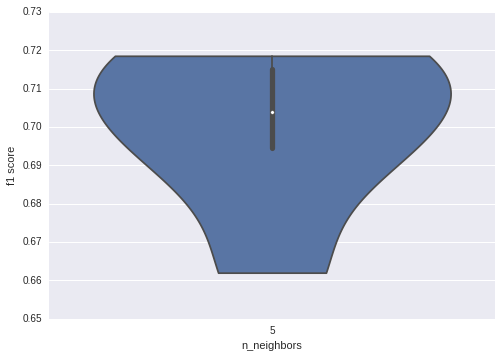

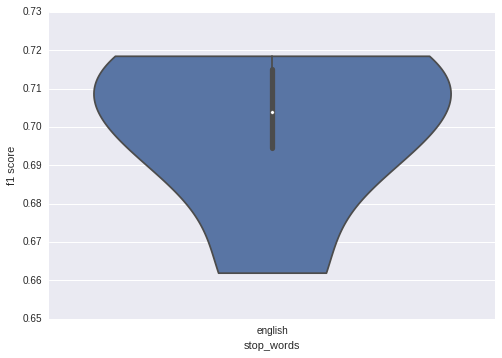

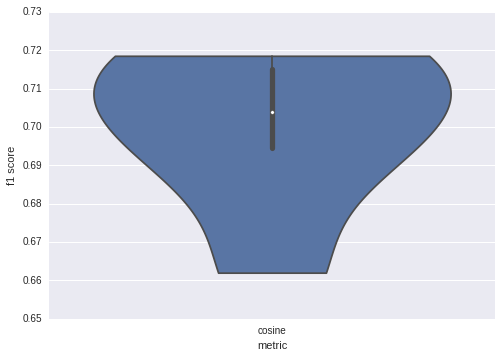

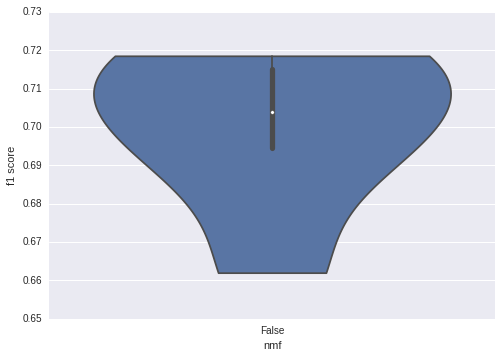

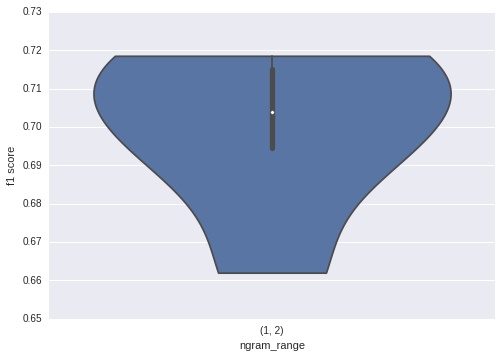

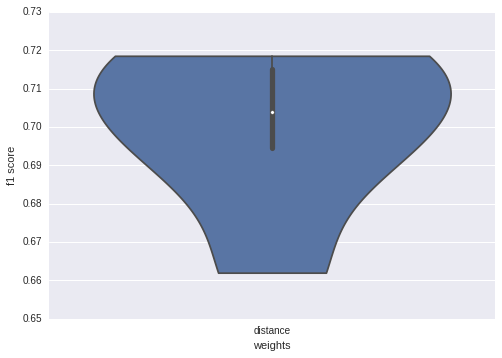

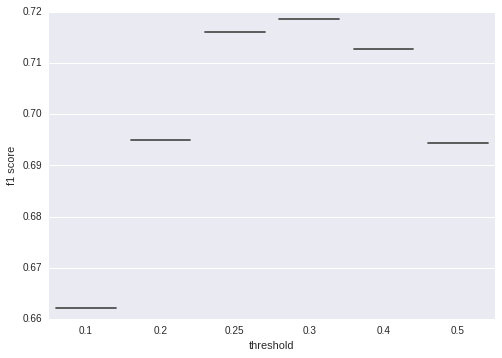

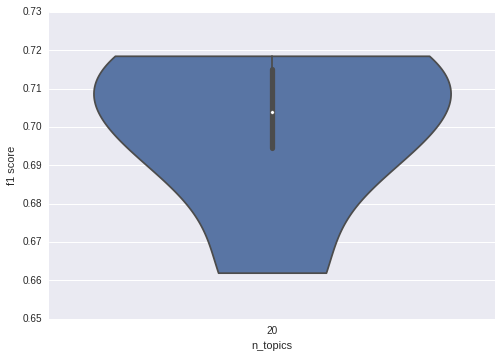

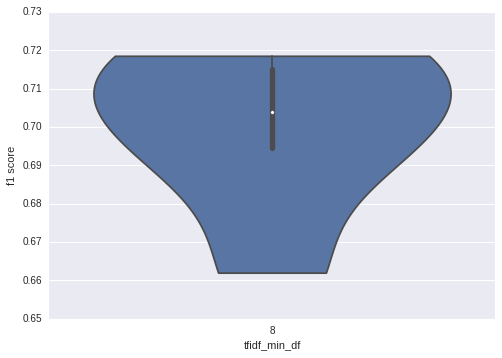

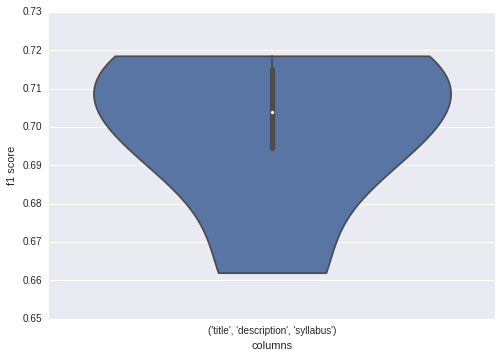

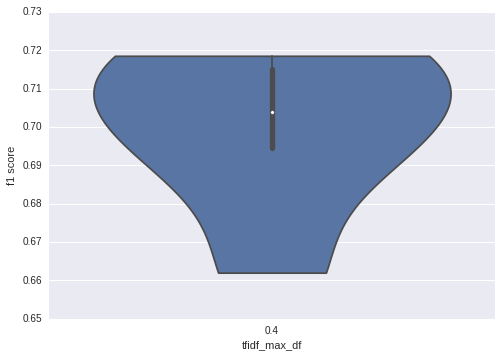

In [28]:
for param_of_interest in gcv.best_params_.keys():
    scores = list()
    for i in gcv.grid_scores_:
        params = i.parameters
        score = i.mean_validation_score
        param_val = params[param_of_interest]
        if param_val is None:
            param_val = 'None'
        if isinstance(param_val, list):
            param_val = tuple(param_val)
        if score > 0:
            scores.append((param_val, score))
    sns.violinplot(data=pd.DataFrame(columns=[param_of_interest, 'f1 score'], data=scores), 
                   x=param_of_interest, y='f1 score', cut=0)
    if not os.path.isdir('KNN_grid_search_cv/'):
        os.makedirs('KNN_grid_search_cv/')
    plt.savefig('KNN_grid_search_cv/KNN_' + param_of_interest.replace(" ", "_") + '.png', dpi=150)
    plt.show()

In [29]:
data = list()
columns = ['precision', 'recall', 'f1', 'roc_auc','support']
for train_idx, test_idx in tqdm(LeaveOneLabelOut(df['fold_num']), total=len(pd.unique(df['fold_num']))):
    fold_clf = CLF(**gcv.best_params_)
    fold_clf.fit(df.iloc[train_idx], df['tag'].iloc[train_idx])
    fold_scores = fold_clf.score_all(df.iloc[test_idx], df['tag'].iloc[test_idx])
    for tag in fold_clf.get_tag_names():
        d = tuple([tag] + [fold_scores[i][tag] for i in columns])
        data.append(d)

cf_results = pd.DataFrame(columns=['tag'] + columns, data=data)

100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


In [35]:
def average_tag_score(gdf):
    d = list()
    try:
        for i in columns[:-1]:
            d.append(np.average(gdf[i], weights=gdf['support']))
    except ZeroDivisionError:
        d = [np.nan] * len(columns[:-1])
    d.append(gdf['support'].sum())
    return pd.DataFrame(columns=columns, data=[tuple(d)])
sort_by = 'f1'
scores_per_tag = cf_results.groupby(by='tag').apply(average_tag_score)
scores_per_tag.sort_values(by=sort_by, inplace=True, ascending=False)
pd.set_option('display.max_rows', len(scores_per_tag))
display(scores_per_tag)
pd.reset_option('display.max_rows')

,,precision,recall,f1,roc_auc,support
tag,,,,,,
video,0,0.983323,1.000000,0.991523,0.553879,406.0
probabilistic_graphical_model,0,0.821429,1.000000,0.891156,0.996472,7.0
mooc,0,0.808576,0.965174,0.879217,0.939621,201.0
in_depth,0,0.815238,0.948882,0.876386,0.850094,313.0
genomic_proteomic_data,0,0.833333,0.875000,0.836111,0.963249,16.0
genetics,0,0.782222,0.800000,0.756667,0.963280,15.0
business_analytics,0,0.701405,0.807018,0.741959,0.928895,57.0
clustering,0,0.833333,0.666667,0.722222,0.908359,6.0
spark,0,0.796296,0.666667,0.705820,0.879044,9.0


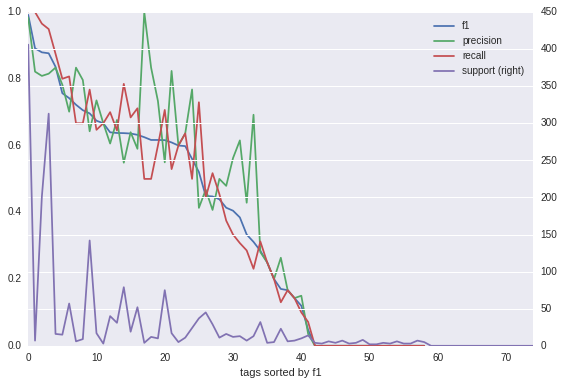

In [37]:
scores_per_tag['x'] = range(len(scores_per_tag))
fig, ax = plt.subplots()
scores_per_tag.plot(x='x', y=['f1', 'precision', 'recall', 'support'], secondary_y=['support'], ax=ax)
ax.set_xlabel('tags sorted by ' + sort_by)
out_dir = 'results/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
plt.tight_layout()
plt.savefig(out_dir + 'knn.png', dpi=150)
plt.show()